# Prepare some things

## Load some modules

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

import numpy as np

import sklearn.metrics
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

In [2]:
# Load the VaDE model class and some custom functions
from models import get_vae_model, get_clustering_vae_model
from evaluate_model import evaluate_clustering_performance
from draw_embeddings import draw_embeddings, draw_clusters_assignments, compare_reconstructed_images_MNIST

## Load and prepare the MNIST data set

In [3]:
(x_train, y_train), (x_test, y_test) = (mnist.load_data())

x_train = x_train.reshape(-1, 28*28).astype("float")/255
x_test = x_test.reshape(-1, 28*28).astype("float")/255

# Pretrain the model

## Construct and pretrain the autoencoder

In [4]:
IMG_DIM = 28*28
LATENT_DIM = 10
INTERMEDIATE_DIMS = (512, 512, 2048)

EPOCHS = 50
BATCH_SIZE = 128

model_vae = get_vae_model(IMG_DIM, LATENT_DIM, INTERMEDIATE_DIMS)

# model_vae.encoder.summary()
# model_vae.decoder.summary()

In [5]:
# model_vae.compile(optimizer=keras.optimizers.Adam())

# model_vae.fit(x_train,
#                epochs=EPOCHS,
#                batch_size=128,
#                verbose=2,
#               )

# model_vae.save_weights("model_weights/cvae/pretrained/vae")

model_vae.load_weights("model_weights/cvae/pretrained/vae")

## Show the resulting embeddings

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


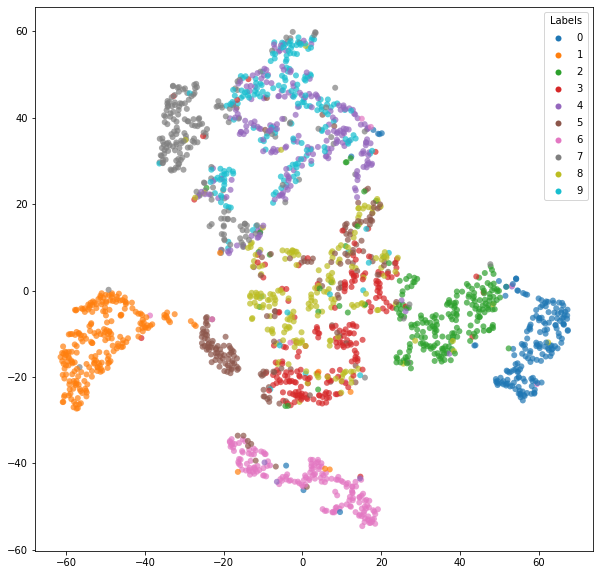

In [6]:
if LATENT_DIM == 2:
    z_train = model_vae.encode_only_mu(x_train)
    draw_embeddings(z_train, y_train)
else:
    z_test = model_vae.encode_only_mu(x_test)
    tsne = TSNE(n_components=2, init='pca')
    z_tsne = tsne.fit_transform(z_test[0:2000])
    draw_embeddings(z_tsne, y_test[0:2000], alpha=0.7)

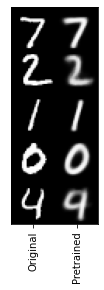

In [7]:
compare_orig_vs_pretrained = compare_reconstructed_images_MNIST(x_test, model_vae.encoder, model_vae.decoder, ("Original", "Pretrained"))

# Fine-tune the model (K-Means)

## Construct the full VaDE model

Load the pretrained weights for the encoder and decoder modules:

In [8]:
model_vae.load_weights("model_weights/cvae/pretrained/vae")

Construct the VaDE model:

In [9]:
N_CLUSTERS = 10
CLUSTERING_LOSS_WEIGHT = 0.1

EPOCHS = 100
BATCH_SIZE = 128
SCHEDULE = 10
DELTA_THRESHOLD = 0.01

model_cvae = get_clustering_vae_model(model_vae, N_CLUSTERS, CLUSTERING_LOSS_WEIGHT)

We will need some functions to initialize the parameters and to train the model (using callbacks):

In [10]:
def update_p(q):
    """
    Compute the auxiliary distirbution P and update it
    Q = {q_ij} = soft cluster assignments
                      q_ij^2 / f_j
    P = {p_ij} = -------------------------
                  Sum_ij' (q_ij^2 / f_j')
    """
    weight = q ** 2 / tf.reduce_sum(q, axis=0)
    p = tf.transpose(tf.transpose(weight) / tf.reduce_sum(weight, axis=1))
    return p.numpy()


def delta_label(c_train):
    global c_last
    delta_label = np.sum(c_train != c_last).astype(np.float32) / c_train.shape[0]
    c_last = np.copy(c_train)
    print(f"Delta: {delta_label:.3f}")
    return delta_label


def cvae_callback(epoch, logs):
    global p
    if (epoch+1) % SCHEDULE == 0:
        q = model_cvae.soft_assignment(x_train)
        p = update_p(q)
        
        c_train = q.numpy().argmax(1)
        if (delta_label(c_train) < DELTA_THRESHOLD):
            model_cvae.stop_training = True
            
callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=cvae_callback)

## Initialize the parameters

Initialize the model parameters from a K-means:

In [11]:
z_train = model_cvae.encode_only_mu(x_train)

kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=30)
kmeans.fit(z_train)

for weight in model_cvae.trainable_weights:
    if weight.name == "centroids:0":
        weight.assign(K.constant(kmeans.cluster_centers_))

Initialize `p`, the auxiliary distribution to compute the clustering loss, and `c_last`, the last cluster assignments to compute the number of points that changed clusters.

In [12]:
p = update_p(to_categorical(kmeans.labels_))
c_last = kmeans.labels_

Evaluate the clustering performance before fine-tunning the model:

In [13]:
# Show the embeddings and the cluster centroids on the latent space
if LATENT_DIM == 2:
    z_train = model_vae.encode_only_mu(x_train)
    draw_embeddings(z_train, y_train, centroids=kmeans.cluster_centers_)

Acc: 0.5006
ARI: 0.3032
AMI: 0.4443
Sil: 0.2189


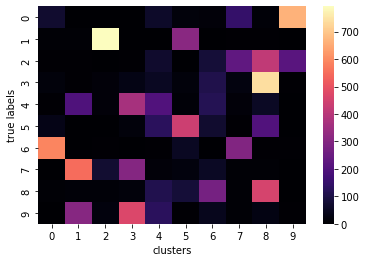

In [14]:
evaluate_clustering_performance(model_cvae.classify, x_test, y_test, True, model_cvae.encode_only_mu)

## Train the model

Train the model:

In [17]:
# model_cvae.compile(optimizer=keras.optimizers.Adam())

# model_cvae.fit(x_train, p,
#                epochs=EPOCHS,
#                batch_size=128,
#                callbacks = callback,
#                verbose=2,
#               )

# model_cvae.save_weights("model_weights/cvae/finetuned/cvae_kmeans")

model_cvae.load_weights("model_weights/cvae/finetuned/cvae_kmeans")

## Show the resulting embeddings

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


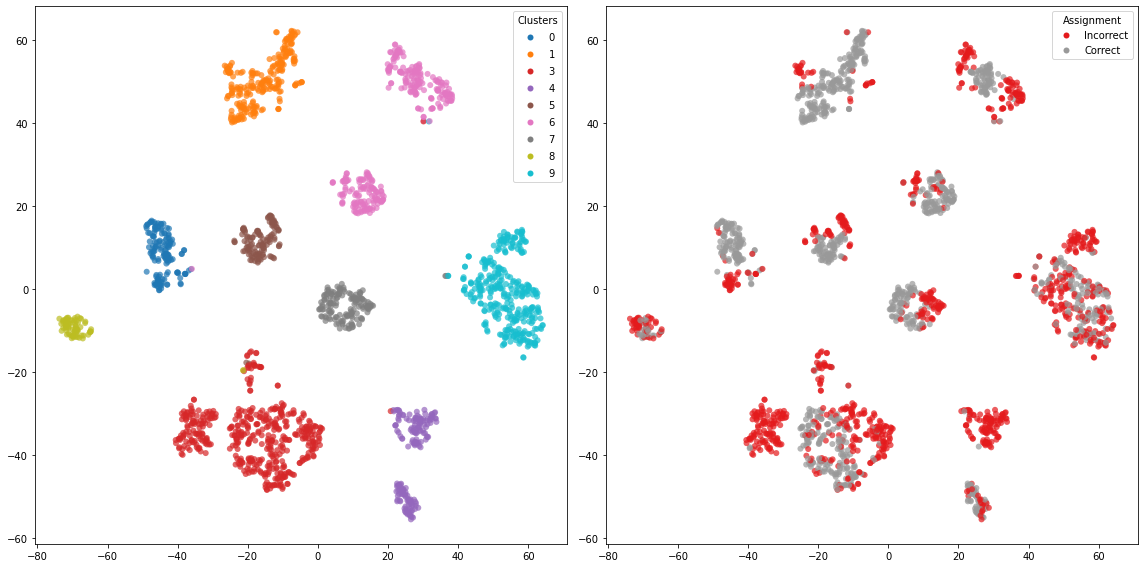

In [18]:
z_test = model_cvae.encode_only_mu(x_test)
c_test = model_cvae.classify(x_test)

if LATENT_DIM == 2:
    draw_clusters_assignments(z_test, y_test, c_test)
else:
    tsne = TSNE(n_components=2, init='pca')
    z_tsne = tsne.fit_transform(z_test[0:2000])
    draw_clusters_assignments(z_tsne, y_test[0:2000], c_test[0:2000], alpha=0.7)

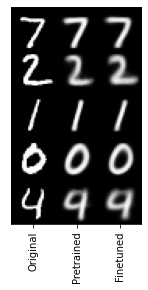

In [19]:
_ = compare_reconstructed_images_MNIST(x_test, model_cvae.encoder, model_cvae.decoder, ("Original", "Pretrained", "Finetuned"), old_figure=compare_orig_vs_pretrained)

## Evaluate the model

Acc: 0.5208
ARI: 0.3306
AMI: 0.4879
Sil: 0.8987


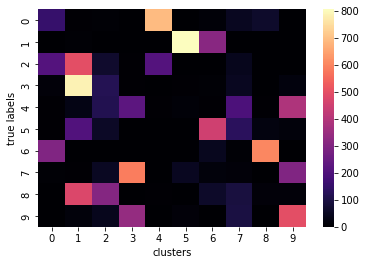

In [20]:
evaluate_clustering_performance(model_cvae.classify, x_test, y_test, True, model_cvae.encode_only_mu)

# Fine-tune the model (GMM)

## Construct the model and load the pretrained weights

Load the pretrained weights for the encoder and decoder modules:

In [21]:
model_vae.load_weights("model_weights/cvae/pretrained/vae")

In [22]:
N_CLUSTERS = 10
CLUSTERING_LOSS_WEIGHT = 0.1

EPOCHS = 100
BATCH_SIZE = 128
SCHEDULE = 10
DELTA_THRESHOLD = 0.01

model_cvae = get_clustering_vae_model(model_vae, N_CLUSTERS, CLUSTERING_LOSS_WEIGHT)

## Initialize the parameters

In [23]:
z_train = model_cvae.encode_only_mu(x_train)

gmm = GaussianMixture(n_components=N_CLUSTERS, covariance_type='diag')
gmm.fit(z_train)

for weight in model_cvae.trainable_weights:
    if weight.name == "centroids:0":
        weight.assign(K.constant(gmm.means_))

In [24]:
p = update_p(to_categorical(gmm.predict(z_train)))
c_last = gmm.predict(z_train)

Evaluate the clustering performance before fine-tunning the model:

In [25]:
# Show the embeddings and the cluster centroids on the latent space
if LATENT_DIM == 2:
    z_train = model_vae.encode_only_mu(x_train)
    draw_embeddings(z_train, y_train, centroids=gmm.means_)

Acc: 0.4689
ARI: 0.2817
AMI: 0.4153
Sil: 0.1732


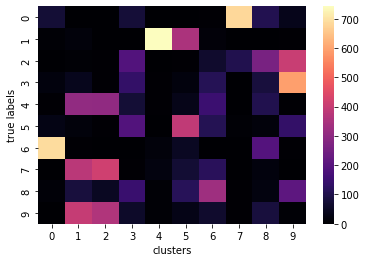

In [26]:
evaluate_clustering_performance(model_cvae.classify, x_test, y_test, True, model_cvae.encode_only_mu)

## Train the model

In [27]:
# model_cvae.compile(optimizer=keras.optimizers.Adam())

# model_cvae.fit(x_train, p,
#                epochs=EPOCHS,
#                batch_size=128,
#                callbacks = callback,
#                verbose=2,
#               )

# model_cvae.save_weights("model_weights/cvae/finetuned/cvae_gmm")

model_cvae.load_weights("model_weights/cvae/finetuned/cvae_gmm")

## Show the resulting embeddings

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


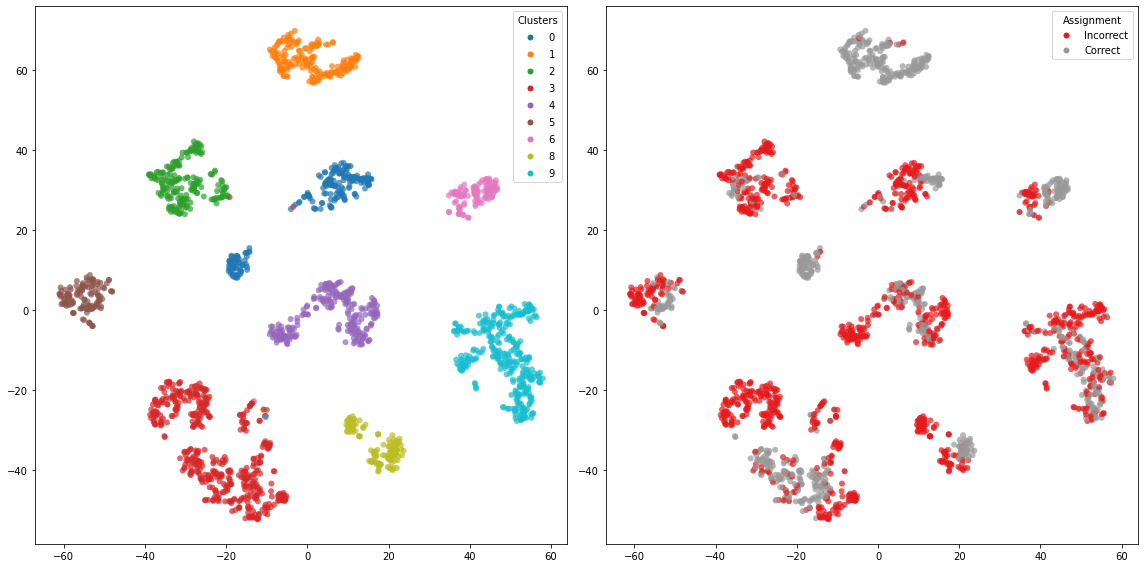

In [28]:
z_test = model_cvae.encode_only_mu(x_test)
c_test = model_cvae.classify(x_test)

if LATENT_DIM == 2:
    draw_clusters_assignments(z_test, y_test, c_test)
else:
    tsne = TSNE(n_components=2, init='pca')
    z_tsne = tsne.fit_transform(z_test[0:2000])
    draw_clusters_assignments(z_tsne, y_test[0:2000], c_test[0:2000], alpha=0.7)

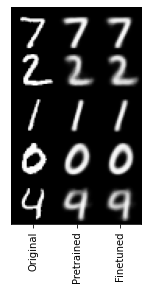

In [29]:
_ = compare_reconstructed_images_MNIST(x_test, model_cvae.encoder, model_cvae.decoder, ("Original", "Pretrained", "Finetuned"), old_figure=compare_orig_vs_pretrained)

## Evaluate the model

Acc: 0.4499
ARI: 0.2774
AMI: 0.4202
Sil: 0.8981


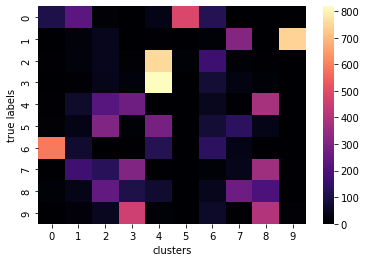

In [ ]:
evaluate_clustering_performance(model_cvae.classify, x_test, y_test, True, model_cvae.encode_only_mu)